In [ ]:
#@title import libs and define util functions
import pandas as pd
from os import listdir
from os.path import isfile, join
import glob
import random
from datetime import datetime
import itertools
from itertools import combinations

from IPython.core.display import display
from tabulate import tabulate
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn.metrics import roc_curve, auc
import numpy as np
import re
import statistics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import zero_one_loss



from scipy.stats import friedmanchisquare, wilcoxon
!pip install scikit_posthocs
import scikit_posthocs as sp
!pip install autorank
from autorank import autorank, plot_stats, create_report, latex_table

!pip install researchpy
import researchpy

from scipy.stats import mannwhitneyu


def create_ranking_df(metric_dict, reverse=True):
  ranking_dict = {}
  for ts in metric_dict:
    ranking_dict[ts] = {}
    sorted_row = sorted(list(metric_dict[ts].values()), reverse=reverse)
    for cl in metric_dict[ts].keys():
      for s in range(len(sorted_row)):
        if metric_dict[ts][cl]==sorted_row[s]:
          ranking_dict[ts][cl] = s+1
          nsr = sorted_row.copy()
          del nsr[s]
          if sorted_row[s] in nsr:
            ranking_dict[ts][cl] = (len(classifiers_keys)+1)/2
          break
  ranking_df = pd.DataFrame(ranking_dict).T
  return ranking_df

def stats(ranking_df, alpha=0.05):
  args = []
  for i in list(ranking_df.columns):
    args.append(ranking_df[i])

  spRes = friedmanchisquare(*args)
  print(spRes)
  if(spRes[1]<=alpha):
    print("the null hp is rejected for alpha <= "+str(alpha))
  else:
    print("the null hp cannot be rejected for alpha <= "+str(alpha))
  nemenyi_pvalues = sp.posthoc_nemenyi_friedman(ranking_df)
  print(nemenyi_pvalues)
  wilc_test = [wilcoxon(ranking_df[i],ranking_df[j]) for i,j in itertools.combinations(ranking_df.columns,2)]
  w_res = pd.DataFrame(wilc_test)
  w_res['test'] = ["wilcoxon " + i+" vs "+j for i,j in itertools.combinations(ranking_df.columns,2)]
  print(w_res)

def stats_(ranking_df, alpha=0.05):
  args = []
  for i in list(ranking_df.columns):
    args.append(ranking_df[i])

  spRes = friedmanchisquare(*args)
  # print(spRes)
  # if(spRes[1]<=alpha):
  #   print("the null hp is rejected for alpha <= "+str(alpha))
  # else:
  #   print("the null hp cannot be rejected for alpha <= "+str(alpha))
  nemenyi_pvalues = sp.posthoc_nemenyi_friedman(ranking_df)
  # print(nemenyi_pvalues)
  wilc_test = [wilcoxon(ranking_df[i],ranking_df[j]) for i,j in itertools.combinations(ranking_df.columns,2)]
  w_res = pd.DataFrame(wilc_test)
  w_res['test'] = ["wilcoxon " + i+" vs "+j for i,j in itertools.combinations(ranking_df.columns,2)]
  # print(w_res)
  return spRes, nemenyi_pvalues, w_res



def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    Pos = 0
    Neg = 0

    for i in range(len(y_hat)):
        if y_actual[i]==1:
          Pos += 1
        else:
          Neg += 1
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(Pos, Neg, TP, FP, TN, FN)

def getMetricsFromConfusionMatrix(TP, FP, TN, FN):
  metrics = {}
  metrics['Precision'] = 0 if (TP+FP==0) else (TP / (TP + FP))
  metrics['Recall'] = 0 if (TP+FN==0) else (TP / (TP + FN))
  metrics['F1'] = 0 if (metrics['Precision'] + metrics['Recall'] == 0) else ((2 * metrics['Precision'] * metrics['Recall']) / (metrics['Precision'] + metrics['Recall']))
  return metrics

def abline(slope, intercept, plt):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    return (x_vals, y_vals)

def cohenDelta(df_0, df_1):
  des, res = researchpy.ttest(df_0, df_1)
  d = float(res.loc[(res['Independent t-test']=="Cohen's d = "), "results"])
  magnitude = getDeltaMagnitude(d)
  return d, magnitude

def HedgeGamma(distr_0, distr_1):
  m_0 = statistics.mean(distr_0)
  m_1 = statistics.mean(distr_1)
  var_0 = statistics.stdev(distr_0)**2
  var_1 = statistics.stdev(distr_1)**2
  n_0 = len(distr_0)
  n_1 = len(distr_1)
  d = (m_0 - m_1) / np.sqrt((((n_0 - 1)*var_0 + (n_1 - 1)*var_1) / (n_0 + n_1 - 2)))
  g = d * (1 - (3 / ((4*(n_0 + n_1)) - 9)))
  return d, g, getDeltaMagnitude(g)


def getDeltaMagnitude(d):
  if abs(d) < 0.2:
    magnitude = 'none'
  elif 0.2 <= abs(d) < 0.5:
    magnitude = "small"
  elif 0.5 <= abs(d) < 0.8:
    magnitude = "medium"
  else:
    magnitude = "large"
  return magnitude

def ignoreTestSet(testset_name, list_to_ignore):
  for e in list_to_ignore:
    if e in testset_name:
      return True
  return False

======= Results Data to evaluate ======= 
           ling17    km-500  norbert_pretrained
Trial 1  0.508772  0.531646            0.563380
Trial 2  0.871166  0.913669            0.965986
Trial 3  0.973451  0.929577            0.975806
Trial 4  0.975904  1.000000            0.974684
Trial 5  0.958333  0.930233            1.000000

Running Autorank....
Rejecting null hypothesis that data is normal for column ling17 (p=0.010691<0.016667)
Rejecting null hypothesis that data is normal for column km-500 (p=0.012064<0.016667)
Rejecting null hypothesis that data is normal for column norbert_pretrained (p=0.001021<0.016667)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.976107>=0.050000)
Using Friedman test as omnibus test
Fail to reject null hypothesis that there is no difference between the distributions (p=0.246597)
RankResult(rankdf=
                    meanrank    median       mad  ci_lower  ci_upper  \
ling17      

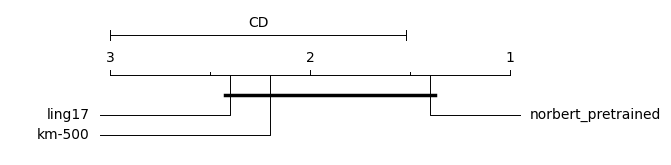


Creating Latex Table...
\begin{table}[h]
\centering
\begin{tabular}{lrrll}
\toprule
 & MR & MED & MAD & CI \\
\midrule
ling17 & 2.400 & 0.958 & 0.018 & [0.509, 0.976] \\
km-500 & 2.200 & 0.930 & 0.016 & [0.532, 1.000] \\
norbert_pretrained & 1.400 & 0.975 & 0.009 & [0.563, 1.000] \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}

.........................
{'Omnibus': 'p$^f$=0.247', 'ling17 vs km-500': '', 'ling17 vs norbert_pretrained': '', 'km-500 vs norbert_pretrained': ''}


In [ ]:
########################################################################
# You can replace the following with your data
# You can actually read it from csv
classifiers_keys = []
results_data = {}
#########################################################################


print("======= Results Data to evaluate ======= ")
print(pd.DataFrame(results_data).T)
print()
print("Running Autorank....")
result = autorank(pd.DataFrame(results_data).T, alpha=0.05, verbose=True)
print(result)

print()
print("Plotting stats...")
try:
  plot_stats(result, allow_insignificant=True)
  plt.show()
except:
  pass

print()
print("Creating Latex Table...")
latex_table(result)

print()
print(".........................")
ranking_df = create_ranking_df(results_data)

stat_values = {}
stat_values['Omnibus'] = "p"+( "$^a$" if result.omnibus=='anova' else "$^f$")+"="+str(round(result.pvalue,3))
if result.pvalue<=0.05:
  stat_values['Omnibus'] = "\cellcolor{yellow!25}"+stat_values['Omnibus']+"*"
  if result.pvalue<=0.01:
    stat_values['Omnibus'] = stat_values['Omnibus']+"*"
  if result.posthoc=='nemenyi':
    for i,j in itertools.combinations(ranking_df.columns,2):
      d, g, magnitude = HedgeGamma(list(pd.DataFrame(results_data).T[i]), list(pd.DataFrame(results_data).T[j]))
      # Using Nemenyi post-hoc test. Differences are significant, if the distance between the mean ranks is greater than the critical distance.
      if abs(result.rankdf.loc[i]['meanrank']-result.rankdf.loc[j]['meanrank'])>result.cd:
        stat_values[str(i)+" vs "+str(j)] = "\cellcolor{yellow!25}"+str(abs(round(d,3)))+" ("+magnitude+")"
      else:
        stat_values[str(i)+" vs "+str(j)] = str(abs(round(d,3)))+" ("+magnitude+")"
  elif result.posthoc=='tukeyhsd':
    for i,j in itertools.combinations(ranking_df.columns,2):
      d, g, magnitude = HedgeGamma(list(pd.DataFrame(results_data).T[i]), list(pd.DataFrame(results_data).T[j]))
      #Using Tukey HSD post hoc test. Differences are significant if the confidence intervals of the mean values are *not* overlapping.
      overlap = max(0, min(result.rankdf.loc[i]['ci_upper'], result.rankdf.loc[j]['ci_upper']) - max(result.rankdf.loc[i]['ci_lower'], result.rankdf.loc[j]['ci_lower']))
      if overlap<=0:
        stat_values[str(i)+" vs "+str(j)] = '\cellcolor{yellow!25}'+str(abs(round(d,3)))+" ("+magnitude+")"
      else:
        stat_values[str(i)+" vs "+str(j)] = str(abs(round(d,3)))+" ("+magnitude+")"
  else:
    print("NOT SUPPORTED YET")
else:
    for i,j in itertools.combinations(ranking_df.columns,2):
        stat_values[str(i)+" vs "+str(j)] = ""

print(stat_values)

